Convolutional Variational Autoencoder

Authored by David Luong

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import sys
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt # for plotting model loss
import json
from tensorflow.keras.preprocessing import sequence
# fix random seed for reproducibility
tf.random.set_seed(7)

#Import svm model
from sklearn import svm
#Import random forest model
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

#Import knn model
from sklearn.neighbors import KNeighborsClassifier

# Final evaluation of the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import plot_confusion_matrix, recall_score, precision_score
from sklearn.naive_bayes import GaussianNB

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])

Run Settings

In [2]:
# malware family
real_malware = 'Mixed' # OnLineGames, Renos, VBInject, WinWebSec, Zbot, Mixed

# data processing
use_harshit = 0 # 0 = use our samples, other to use Harshit's fake samples
unique_opcodes = 1 # 0 = visualize_explore/opcodes, 1 = fake_tests/opdicts

# VAE generator parameters
max_sequence_length = 600 # number of opcodes at the input layer (same as maximum length sequence)
latent_dim = 2 # latent space dimension
num_epochs = 30
num_batch_size = 16
use_trained_weights = 1 # 0 = train VAE, 1 = use saved train weights

# Classifier parameters
embedding_vector_length = 32
use_deep_classifiers = 1
run_classifiers = 1
use_kfold_deep_classifiers = 0
target_names = ['Authentic', 'Synthetic']
classify_test_size = 0.2

# save directory
fp = './results/vae_cnn/'
write_opcode_files = 0
write_opcode_images = 0

# derived parameters
if real_malware == 'WinWebSec':
    fake_malware = 'wws'
    savedir_malware = 'wws'
    top_opcodes = 22
elif real_malware == 'OnLineGames':
    fake_malware = 'olgames'
    savedir_malware = 'olgames'
    top_opcodes = 22
elif real_malware == 'Renos':
    fake_malware = 'renos'
    savedir_malware = 'renos'
    top_opcodes = 22
elif real_malware == 'VBInject':
    fake_malware = 'vbinject'
    savedir_malware = 'vbinject'
    top_opcodes = 25
elif real_malware == 'Zbot':
    fake_malware = 'zbot'
    savedir_malware = 'zbot'
    top_opcodes = 20
elif real_malware == 'Mixed':
    fake_malware = 'mixed'
    savedir_malware = 'mixed'
    top_opcodes = 41
else:
    print('!!!Malware not found!!!')

Define Sampling Layer

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding an opcode sequence."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Define Encoder

In [4]:
input_shape = (max_sequence_length,1)

encoder_inputs = keras.Input(shape=input_shape)
x = layers.Conv1D(128, kernel_size=3, activation='relu', padding="same")(encoder_inputs)
x = layers.Conv1D(64, kernel_size=3, activation='relu', padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 600, 128)     512         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 600, 64)      24640       ['conv1d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 38400)        0           ['conv1d_1[0][0]']               
                                                                                            

Define Decoder

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(max_sequence_length * 32, activation="relu")(latent_inputs)
x = layers.Reshape((max_sequence_length, 32))(x)
x = layers.Conv1DTranspose(32, 3, activation="relu", padding="same")(x)
x = layers.Conv1DTranspose(16, 3, activation="relu", padding="same")(x)
decoder_outputs = layers.Conv1DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 19200)             57600     
                                                                 
 reshape (Reshape)           (None, 600, 32)           0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 600, 32)          3104      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 600, 16)          1552      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 600, 1)           49  

Define VAE Class, Loss Function

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            print(data)
            print(z)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=1
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Define helper functions

In [7]:
# function to get unique values
def unique(list1):
    # initialize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

# Python code to count the number of occurrences
def countX(lst, x):
    count = 0
    for ele in lst:
        if (ele == x):
            count = count + 1
    return count

# opcodes are indexed by overall frequency
def get_opcode_freq(opcode_frequency):
    rank = 0
    prev_count = -1
    for item in sorted(opcode_frequency,reverse=True):
        # increment rank if current opcode has different frequency than previous opcode
        if prev_count != item[0]:
            rank+=1
        # assign frequency rank
        opcode_frequency[item[1]] = rank
        # save previous frequency
        prev_count = item[0]
    return opcode_frequency

# opcodes are indexed by unique opcode position (opcodes_into_list)
def get_opcode_pos(data_into_list,opcodes_into_list):
    opcode_position = []
    nx = 0
    for x in data_into_list:
        ny = 0
        for y in opcodes_into_list:
            if x == y:
                opcode_position.append(ny)
                break
            ny+=1
        nx+=1
        # index for unknown opcodes
        if len(opcodes_into_list) == ny:
            opcode_position.append(ny)
    return opcode_position

# get opcode list from opdict
def get_opcode_dict(malware_fam,file_path):
    my_opcodes = file_path + 'opdict' + malware_fam + '.json'
    with open(my_opcodes) as json_file:
        data = json.load(json_file)
    return list(data.keys())

Load Real Malware Files

In [8]:
# initialize variables
dataset = []
dataset_names = []
dataset_ind = []

# opening list of unique opcodes
if unique_opcodes == 0:
    my_fp = './code/visualize_explore/opcodes/'
    my_opcodes = open(my_fp + 'opcodes' + real_malware + '.txt','r')
    opcodes = my_opcodes.read()
    opcodes_into_list = opcodes.replace('\n', ' ').split(" ")
    opcodes_into_list.remove('')
    # close opcodes file
    my_opcodes.close()
elif unique_opcodes == 1:
    my_fp = main_dir + '/code-20230116T073801Z-001/code/fake_tests/opdicts/'
    opcodes_into_list = get_opcode_dict(real_malware,my_fp)

# real malware parameters
my_filepath = "../malware_data/" + real_malware +'/'
dir_list = os.listdir(my_filepath)

# process real malware
for fm in dir_list:
    # if f == 'VirusShare_07c88839c083ddf7ecb11e7bfde38ea8.txt': # debug
    print('Processing real malware' + my_filepath + fm)

    # opening the file in read mode
    my_file = open(my_filepath + fm, "r")

    # reading the file
    data = my_file.read()

    # replacing end of line('/n') with ' ' and
    # splitting the text it further when '.' is seen.
    data_into_list = data.replace('\n', ' ').split(" ")

    # remove '' from opcodes
    data_into_list.remove('')

    opcode_frequency = []
    if len(data_into_list) >= max_sequence_length: # include malware with at least max_sequence_length number of opcodes
            
        # create (opcode frequency, rank) tuple
        idx = 0
        for x in opcodes_into_list:
            count = countX(data_into_list, x)
            #print('{} has occurred {} times'.format(x,count))
            opcode_frequency.append((count,idx))
            idx+=1
        # print(sorted(opcode_frequency,reverse=True))

        # opcodes are indexed by overall frequency
        opcode_frequency = get_opcode_freq(opcode_frequency)

        # opcodes are indexed by opcodes_into_list position
        opcode_position = get_opcode_pos(data_into_list,opcodes_into_list)

        # add real malware to dataset
        dataset.append(opcode_position)
        dataset_names.append(fm)
        dataset_ind.append(0) # 0 is indicator for real malware
    else:
        # skip processing if malware file is empty
        print('------------> is less than ' + str(max_sequence_length) + ' ... skipping')

    # close file
    my_file.close()

# convert dataset to numpy arrays
X = np.array(dataset,dtype=object)
y = np.array(dataset_ind,dtype='int64')

# print
nSamples = len(X)
print('There are', nSamples, 'malware files')

# write real malware to images
if write_opcode_images:
    print('Writing real malware images')
    tmp = sequence.pad_sequences(X, maxlen=max_sequence_length, dtype='int32',
        padding='pre', truncating='pre', value=0.)

    for idx,img in enumerate(tmp):
        plt.matshow(np.array(img).reshape(20,30))
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.savefig('./results/' + 'real_malware_images/' + savedir_malware + '/' + 'real_' + real_malware + '_' + str(idx+1) + '.png')
        plt.close()

Processing real malware../malware_data/Mixed/0009d99691e8eed99c7dd1500e07cda336d54260.asm.txt
Processing real malware../malware_data/Mixed/00113d9802cca3deba19cf9daa17f1c2269de2b8.asm.txt
------------> is less than 600 ... skipping
Processing real malware../malware_data/Mixed/002c3a4a12eb9cdc80754e4cddccbc98e5769392.asm.txt
Processing real malware../malware_data/Mixed/0036d720d8ff6c8f4860b5c69deba7c400e4d356.asm.txt
Processing real malware../malware_data/Mixed/0037c7716f1dc8e5c4e1f9a9f3e9d5aedb7a6979.asm.txt
Processing real malware../malware_data/Mixed/003824de7a82d2db9fc877c44ea93f76dd0e5ca9.asm.txt
Processing real malware../malware_data/Mixed/003c10125d80ba6cdbb05bc9aa047c7dbaa6b7ff.asm.txt
Processing real malware../malware_data/Mixed/00427746e03afb4d3b28791a82315e52acf66a0b.asm.txt
Processing real malware../malware_data/Mixed/00475573fe331e89916a27a9207f446bacfcf96a.asm.txt
Processing real malware../malware_data/Mixed/004bb59ba37917bfea49e6904f0551df7b3c719f.asm.txt
Processing real 

Prepare training and test datasets

In [9]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# truncate and pad input sequences
X_train = sequence.pad_sequences(X_train, maxlen=max_sequence_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_sequence_length)

# reshape and normalize
norm_factor = 1/(len(opcodes_into_list)+1)
sample_size = X_train.shape[0]
time_steps = X_train.shape[1]
X_train_reshaped = X_train.reshape(sample_size, time_steps, 1)*norm_factor

# reshape and normalize
norm_factor = 1/(len(opcodes_into_list)+1)
sample_size = X_test.shape[0]
time_steps = X_test.shape[1]
X_test_reshaped = X_test.reshape(sample_size, time_steps, 1)*norm_factor

Train VAE and plot loss function

Epoch 1/30
Tensor("IteratorGetNext:0", shape=(None, 600, 1), dtype=float32)
Tensor("encoder/sampling/add:0", shape=(None, 2), dtype=float32)
Tensor("IteratorGetNext:0", shape=(None, 600, 1), dtype=float32)
Tensor("encoder/sampling/add:0", shape=(None, 2), dtype=float32)
3/3 [==============================] - 1s 18ms/step - loss: 416.4063 - reconstruction_loss: 415.5063 - kl_loss: 0.7978
Epoch 2/30
3/3 [==============================] - 0s 21ms/step - loss: 414.1210 - reconstruction_loss: 413.5553 - kl_loss: 0.0943
Epoch 3/30
3/3 [==============================] - 0s 22ms/step - loss: 412.1248 - reconstruction_loss: 411.9995 - kl_loss: 0.0306
Epoch 4/30
3/3 [==============================] - 0s 20ms/step - loss: 409.7671 - reconstruction_loss: 408.8275 - kl_loss: 0.0428
Epoch 5/30
3/3 [==============================] - 0s 19ms/step - loss: 405.6427 - reconstruction_loss: 403.0247 - kl_loss: 0.2332
Epoch 6/30
3/3 [==============================] - 0s 18ms/step - loss: 404.5160 - reconstr

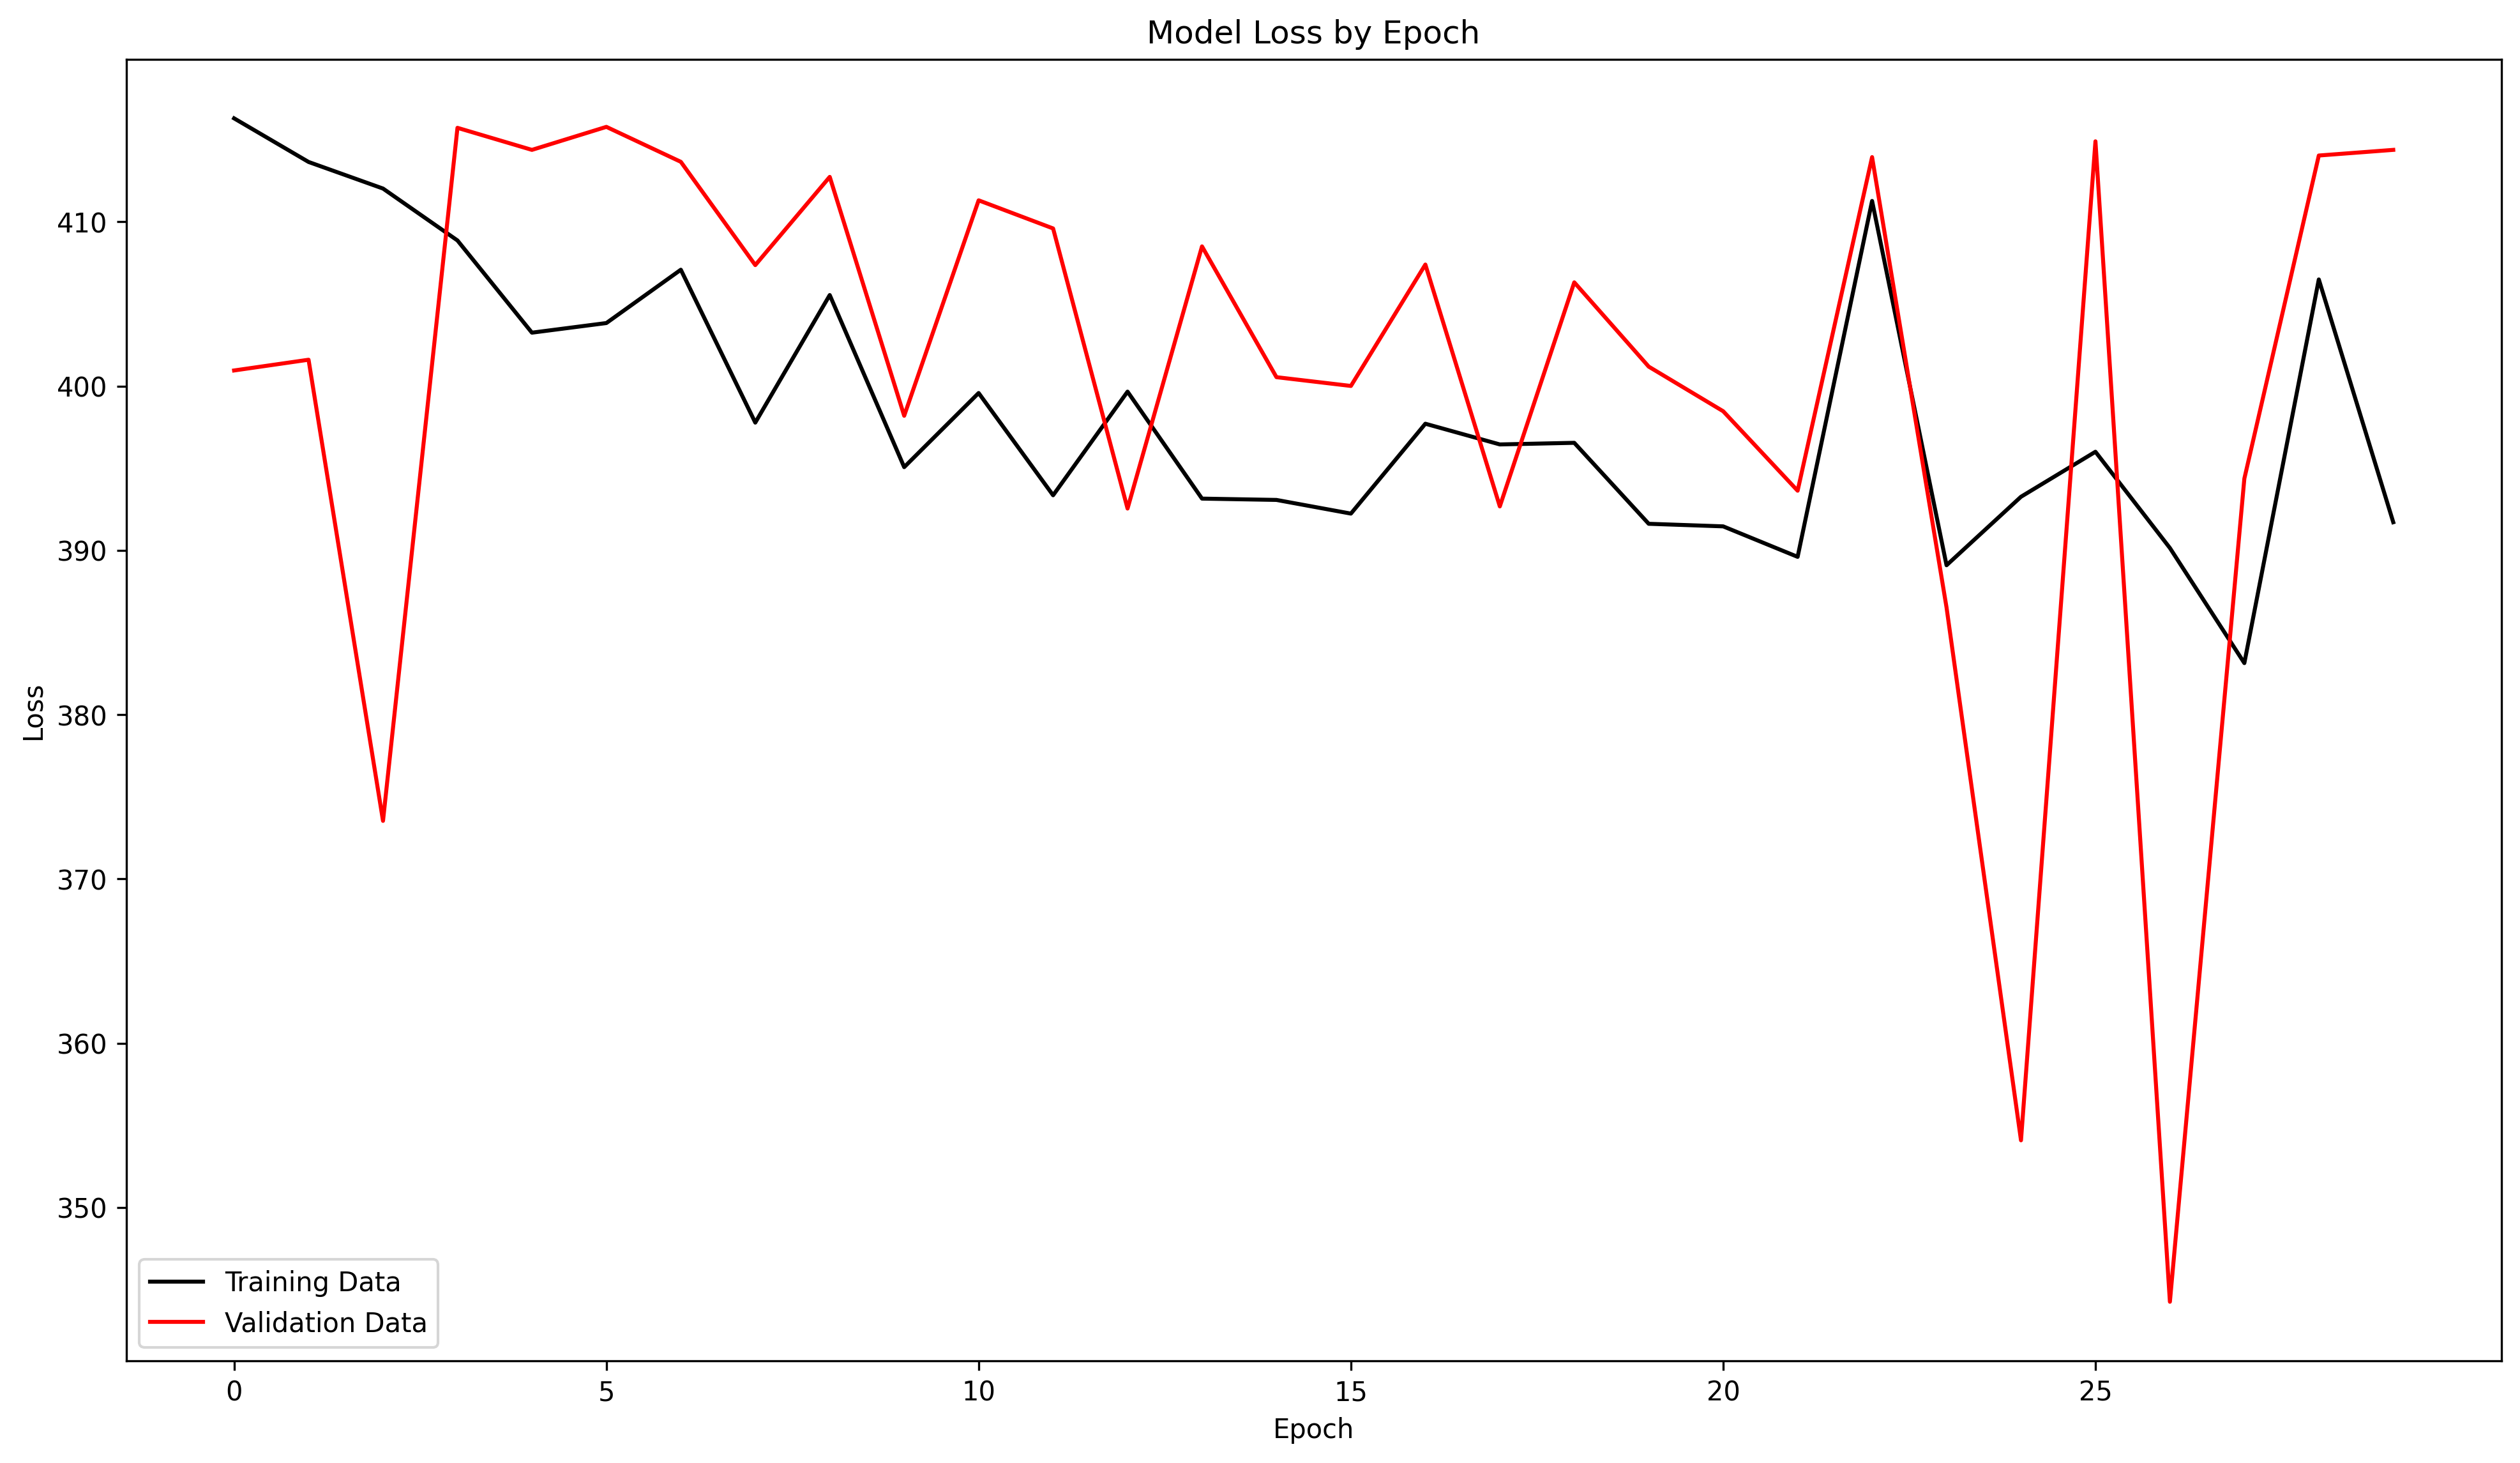

In [10]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

if use_trained_weights:
    print('Using trained weights')
    load_status = vae.load_weights(fp + '/weights/'+fake_malware+'/my_weights_'+real_malware)
else:

    # get train results
    history_train = vae.fit(X_train_reshaped, epochs=num_epochs, batch_size=num_batch_size)

    # save train weights
    print('Saved weights to '+ fp+'weights/'+fake_malware+'/my_weights_'+real_malware)
    vae.save_weights(fp+'weights/'+fake_malware+'/my_weights_'+real_malware)

    # get test results
    history_test = vae.fit(X_test_reshaped, epochs=num_epochs, batch_size=num_batch_size)

    # load train weights
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    load_status = vae.load_weights(fp + '/weights/'+fake_malware+'/my_weights_'+real_malware)

    # Plot a loss chart
    fig, ax = plt.subplots(figsize=(16,9), dpi=300)
    plt.title(label='Model Loss by Epoch', loc='center')

    ax.plot(history_train.history['loss'], label='Training Data', color='black')
    ax.plot(history_test.history['loss'], label='Validation Data', color='red')
    ax.set(xlabel='Epoch', ylabel='Loss')
    plt.xticks(ticks=np.arange(len(history_train.history['loss']), step=5), labels=np.arange(0, len(history_train.history['loss']), step=5))
    plt.legend()

    # save loss chart
    print('Saved loss chart')
    plt.savefig(fp+'my_loss_chart_'+real_malware+'.png')
    plt.show()

Visualize the latent space

Saved latent space chart


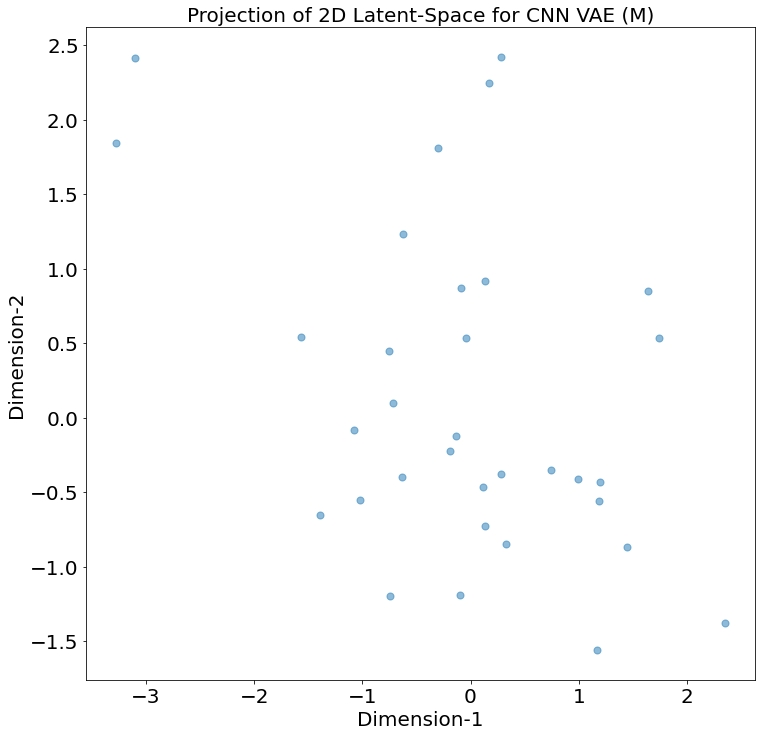

In [11]:
a,b,c = vae.encoder.predict(X_train_reshaped)
embeddings = Sampling()([a, b])

mu = np.mean(a)
sig = np.sqrt(abs(np.mean(b)))

figsize = 12
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0] , embeddings[:, 1], alpha=0.5, s=50)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Projection of 2D Latent-Space for CNN VAE (" + real_malware[0] +")", size=20)

# save latent space chart
print('Saved latent space chart')
plt.savefig(fp+'my_latent_chart_'+real_malware+'.png')

plt.show()

Generate Fake Malware

In [12]:
for nF in range(nSamples):
    randomlist = []
    for i in range(0,latent_dim):
        #n = random.randint(0,len(opcodes_into_list))
        #n = (random.random() - 0.5)*2
        #n = random.random()
        #n = 2*random.random()-1
        n = np.random.normal(mu, sig)
        randomlist.append(n)
    z_sample_opcode=[randomlist]

    # Decode latent inputs (i.e., generate new outputs)
    opcode_decoded = decoder.predict(z_sample_opcode)

    tmp = np.rint(opcode_decoded.reshape(20,30)*len(opcodes_into_list)).astype(int)

    if write_opcode_files:
    # write opcode integers
        my_opcodes = open(fp + 'samples' + '/' + fake_malware + '/' + 'generated_' + real_malware + '_' + str(nF+1) + '.txt','a+')

        for row in tmp:
            for col in row:
                my_opcodes.write(str(col))
                my_opcodes.write('\n')
        # close opcodes file
        my_opcodes.close()

    if write_opcode_images:
        # Reshape and display/save the image
        plt.matshow(tmp)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.savefig(fp + 'images/' + savedir_malware + '/' + 'generated_' + real_malware + '_' + str(nF+1) + '.png')
        plt.close()
    
    # append to fake malware to dataset
    dataset.append(tmp.reshape(1,max_sequence_length)[0])
    dataset_ind.append(1)

Classifier Models

In [13]:
def lstm(X, y, real_malware, target_names, max_sequence_length, embedding_vector_length, num_unique, classify_test_size):
    classifier_name = 'LSTM'
    print('******%s******' % classifier_name)

    # truncate and pad input sequences
    X = sequence.pad_sequences(X, maxlen=max_sequence_length)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=classify_test_size, shuffle=True)
    clf = Sequential()
    clf.add(Embedding(num_unique, embedding_vector_length, input_length=max_sequence_length))
    clf.add(LSTM(100))
    clf.add(Dense(1, activation='sigmoid'))
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])   
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.01, patience=10, restore_best_weights=True)
    clf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[callback], verbose=1)
    scores = clf.evaluate(X_test, y_test, verbose=1)
    accuracy = scores[1]
    y_pred = np.round(clf.predict(X_test))
    precision = precision_score(y_test, y_pred)
    recall= recall_score(y_test, y_pred)

    show_confusion_matrix = False
    if show_confusion_matrix:
        fig, ax = plt.subplots(figsize=(4,4))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.array(target_names), cmap=plt.cm.Blues, ax=ax)
        ax.set_title('%s Confusion Matrix \n using %s'%(real_malware,classifier_name))
        plt.show()
    
    #class_report = classification_report(y_test, y_pred, target_names=target_names) 

    return accuracy, precision, recall#, class_report

def lstm_kfold(X, y, real_malware, target_names, max_sequence_length, embedding_vector_length, num_unique, classify_test_size):
    classifier_name = 'Kfold LSTM'
    print('******%s******' % classifier_name)
    k = int(1/classify_test_size)
    accuracy = []
    precision = []
    recall = []
    best = 0.
    kf = KFold(n_splits=k, shuffle=True, random_state=18245)

    # truncate and pad input sequences
    X = sequence.pad_sequences(X, maxlen=max_sequence_length)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # build LSTM model
        clf = Sequential()
        clf.add(Embedding(num_unique, embedding_vector_length, input_length=max_sequence_length))
        clf.add(LSTM(100))
        clf.add(Dense(1, activation='sigmoid'))
        clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])   
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.01, patience=10, restore_best_weights=True)
        clf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[callback], verbose=1)
        scores = clf.evaluate(X_test, y_test, verbose=1)
        acc = scores[1]
        accuracy.append(acc)
        if acc>best:
            best = acc
            best_train, best_test = train_index, test_index
            
        y_pred = np.round(clf.predict(X_test))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        
    print('\n%s accuracy: ' % classifier_name, accuracy)
    print('%s precision: ' % classifier_name, precision)
    print('%s recall: ' % classifier_name, recall)
    
    print('\nAvg %s accuracy: %0.2f'% (classifier_name, np.mean(np.array(accuracy))))
    print('Avg %s precision: %0.2f'% (classifier_name, np.mean(np.array(precision))))
    print('Avg %s recall: %0.2f\n'% (classifier_name ,np.mean(np.array(recall))))
    
    X_train, X_test, y_train, y_test = X[best_train], X[best_test], y[best_train], y[best_test]
    clf = Sequential()
    clf.add(Embedding(num_unique, embedding_vector_length, input_length=max_sequence_length))
    clf.add(LSTM(100))
    clf.add(Dense(1, activation='sigmoid'))
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])   
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.01, patience=10, restore_best_weights=True)
    clf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[callback], verbose=1)
    y_pred = np.round(clf.predict(X_test))
    
    show_confusion_matrix = False
    if show_confusion_matrix:
        fig, ax = plt.subplots(figsize=(4,4))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.array(target_names), cmap=plt.cm.Blues, ax=ax)
        ax.set_title('%s Confusion Matrix \n using %s'%(real_malware,classifier_name))
        plt.show()
    
    #class_report = classification_report(y_test, y_pred, target_names=target_names) 

    return np.mean(np.array(accuracy)), np.mean(np.array(precision)), np.mean(np.array(recall))#, class_report

def bi_lstm(X, y, real_malware, target_names, max_sequence_length, embedding_vector_length, num_unique, classify_test_size):
    classifier_name = 'Bidirectional_LSTM'
    print('******%s******' % classifier_name)

    # truncate and pad input sequences
    X = sequence.pad_sequences(X, maxlen=max_sequence_length)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=classify_test_size, shuffle=True)
    clf = Sequential()
    clf.add(Embedding(num_unique, embedding_vector_length, input_length=max_sequence_length))
    #clf.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    clf.add(Bidirectional(LSTM(100, dropout=0.2)))
    clf.add(Dense(1, activation='sigmoid'))
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.01, patience=10, restore_best_weights=True)
    clf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[callback], verbose=1)
    scores = clf.evaluate(X_test, y_test, verbose=1)
    accuracy = scores[1]
    y_pred = np.round(clf.predict(X_test))
    precision = precision_score(y_test, y_pred)
    recall= recall_score(y_test, y_pred)

    show_confusion_matrix = False
    if show_confusion_matrix:
        fig, ax = plt.subplots(figsize=(4,4))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.array(target_names), cmap=plt.cm.Blues, ax=ax)
        ax.set_title('%s Confusion Matrix \n using %s'%(real_malware,classifier_name))
        plt.show()
    
    #class_report = classification_report(y_test, y_pred, target_names=target_names) 

    return accuracy, precision, recall#, class_report

def bi_lstm_kfold(X, y, real_malware, target_names,max_sequence_length, embedding_vector_length, num_unique, classify_test_size):
    classifier_name = 'Kfold Bidirectional_LSTM'
    print('******%s******' % classifier_name)
    k = int(1/classify_test_size)
    accuracy = []
    precision = []
    recall = []
    best = 0.
    kf = KFold(n_splits=k, shuffle=True, random_state=18245)

    # truncate and pad input sequences
    X = sequence.pad_sequences(X, maxlen=max_sequence_length)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # build LSTM model
        clf = Sequential()
        clf.add(Embedding(num_unique, embedding_vector_length, input_length=max_sequence_length))
        #clf.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
        clf.add(Bidirectional(LSTM(100, dropout=0.2)))
        clf.add(Dense(1, activation='sigmoid'))
        clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.01, patience=10, restore_best_weights=True)
        clf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[callback], verbose=1)
        scores = clf.evaluate(X_test, y_test, verbose=1)
        acc = scores[1]
        accuracy.append(acc)
        if acc>best:
            best = acc
            best_train, best_test = train_index, test_index
            
        y_pred = np.round(clf.predict(X_test))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        
    print('\n%s accuracy: ' % classifier_name, accuracy)
    print('%s precision: ' % classifier_name, precision)
    print('%s recall: ' % classifier_name, recall)
    
    print('\nAvg %s accuracy: %0.2f'% (classifier_name, np.mean(np.array(accuracy))))
    print('Avg %s precision: %0.2f'% (classifier_name, np.mean(np.array(precision))))
    print('Avg %s recall: %0.2f\n'% (classifier_name ,np.mean(np.array(recall))))
    
    X_train, X_test, y_train, y_test = X[best_train], X[best_test], y[best_train], y[best_test]
    clf = Sequential()
    clf.add(Embedding(num_unique, embedding_vector_length, input_length=max_sequence_length))
    #clf.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    clf.add(Bidirectional(LSTM(100, dropout=0.2)))
    clf.add(Dense(1, activation='sigmoid'))
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.01, patience=10, restore_best_weights=True)
    clf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[callback], verbose=1)
    y_pred = np.round(clf.predict(X_test))
    
    show_confusion_matrix = False
    if show_confusion_matrix:
        fig, ax = plt.subplots(figsize=(4,4))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.array(target_names), cmap=plt.cm.Blues, ax=ax)
        ax.set_title('%s Confusion Matrix \n using %s'%(real_malware,classifier_name))
        plt.show()
    
    #class_report = classification_report(y_test, y_pred, target_names=target_names) 

    return np.mean(np.array(accuracy)), np.mean(np.array(precision)), np.mean(np.array(recall))#, class_report

def cnn_lstm(X, y, real_malware, target_names, max_sequence_length, embedding_vector_length, num_unique, classify_test_size):
    classifier_name = 'CNN_LSTM'
    print('******%s******' % classifier_name)

    # truncate and pad input sequences
    X = sequence.pad_sequences(X, maxlen=max_sequence_length)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=classify_test_size, shuffle=True)
    clf = Sequential()
    clf.add(Embedding(num_unique, embedding_vector_length, input_length=max_sequence_length))
    clf.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    clf.add(MaxPooling1D(pool_size=2))
    clf.add(LSTM(100))
    clf.add(Dense(1, activation='sigmoid'))
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.01, patience=10, restore_best_weights=True)
    clf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[callback], verbose=1)
    scores = clf.evaluate(X_test, y_test, verbose=1)
    accuracy = scores[1]
    y_pred = np.round(clf.predict(X_test))
    precision = precision_score(y_test, y_pred)
    recall= recall_score(y_test, y_pred)

    show_confusion_matrix = False
    if show_confusion_matrix:
        fig, ax = plt.subplots(figsize=(4,4))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.array(target_names), cmap=plt.cm.Blues, ax=ax)
        ax.set_title('%s Confusion Matrix \n using %s'%(real_malware,classifier_name))
        plt.show()
    
    #class_report = classification_report(y_test, y_pred, target_names=target_names) 

    return accuracy, precision, recall#, class_report

def cnn_lstm_kfold(X, y, real_malware, target_names,max_sequence_length, embedding_vector_length, num_unique, classify_test_size):
    classifier_name = 'Kfold CNN_LSTM'
    print('******%s******' % classifier_name)
    k = int(1/classify_test_size)
    accuracy = []
    precision = []
    recall = []
    best = 0.
    kf = KFold(n_splits=k, shuffle=True, random_state=18245)

    # truncate and pad input sequences
    X = sequence.pad_sequences(X, maxlen=max_sequence_length)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # build LSTM model
        clf = Sequential()
        clf.add(Embedding(num_unique, embedding_vector_length, input_length=max_sequence_length))
        clf.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
        clf.add(MaxPooling1D(pool_size=2))
        clf.add(LSTM(100))
        clf.add(Dense(1, activation='sigmoid'))
        clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.01, patience=10, restore_best_weights=True)
        clf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[callback], verbose=1)
        scores = clf.evaluate(X_test, y_test, verbose=1)
        acc = scores[1]
        accuracy.append(acc)
        if acc>best:
            best = acc
            best_train, best_test = train_index, test_index
            
        y_pred = np.round(clf.predict(X_test))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        
    print('\n%s accuracy: ' % classifier_name, accuracy)
    print('%s precision: ' % classifier_name, precision)
    print('%s recall: ' % classifier_name, recall)
    
    print('\nAvg %s accuracy: %0.2f'% (classifier_name, np.mean(np.array(accuracy))))
    print('Avg %s precision: %0.2f'% (classifier_name, np.mean(np.array(precision))))
    print('Avg %s recall: %0.2f\n'% (classifier_name ,np.mean(np.array(recall))))
    
    X_train, X_test, y_train, y_test = X[best_train], X[best_test], y[best_train], y[best_test]
    clf = Sequential()
    clf.add(Embedding(num_unique, embedding_vector_length, input_length=max_sequence_length))
    clf.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    clf.add(MaxPooling1D(pool_size=2))
    clf.add(LSTM(100))
    clf.add(Dense(1, activation='sigmoid'))
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.01, patience=10, restore_best_weights=True)
    clf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[callback], verbose=1)
    y_pred = np.round(clf.predict(X_test))
    
    show_confusion_matrix = False
    if show_confusion_matrix:
        fig, ax = plt.subplots(figsize=(4,4))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.array(target_names), cmap=plt.cm.Blues, ax=ax)
        ax.set_title('%s Confusion Matrix \n using %s'%(real_malware,classifier_name))
        plt.show()
    
    #class_report = classification_report(y_test, y_pred, target_names=target_names) 

    return np.mean(np.array(accuracy)), np.mean(np.array(precision)), np.mean(np.array(recall))#, class_report

def support_vector_machine(X, y, real_malware, target_names, max_sequence_length, classify_test_size):
    classifier_name = 'Support Vector Machines'
    print('******%s******' % classifier_name)
    k = int(1/classify_test_size)
    accuracy = []
    precision = []
    recall = []
    best = 0.
    kf = KFold(n_splits=k, shuffle=True)

    # truncate and pad input sequences
    X = sequence.pad_sequences(X, maxlen=max_sequence_length)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = svm.SVC(C=5, kernel='rbf')
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test)
        accuracy.append(acc)
        if acc>best:
            best = acc
            best_train, best_test = train_index, test_index
            
        y_pred = clf.predict(X_test)
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        
    print('\n%s accuracy: ' % classifier_name, accuracy)
    print('%s precision: ' % classifier_name, precision)
    print('%s recall: ' % classifier_name, recall)
    
    print('\nAvg %s accuracy: %0.2f'% (classifier_name, np.mean(np.array(accuracy))))
    print('Avg %s precision: %0.2f'% (classifier_name, np.mean(np.array(precision))))
    print('Avg %s recall: %0.2f\n'% (classifier_name ,np.mean(np.array(recall))))
    
    X_train, X_test, y_train, y_test = X[best_train], X[best_test], y[best_train], y[best_test]
    clf = svm.SVC(C=5, kernel='rbf')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    show_confusion_matrix = False
    if show_confusion_matrix:
        fig, ax = plt.subplots(figsize=(4,4))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.array(target_names), cmap=plt.cm.Blues, ax=ax)
        ax.set_title('%s Confusion Matrix \n using %s'%(real_malware,classifier_name))
        plt.show()
    
    #class_report = classification_report(y_test, y_pred, target_names=target_names) 

    return np.mean(np.array(accuracy)), np.mean(np.array(precision)), np.mean(np.array(recall))#, class_report

def random_forest(X, y, real_malware, target_names, max_sequence_length, classify_test_size):
    classifier_name = 'Random Forest'
    print('******%s******' % classifier_name)
    k = int(1/classify_test_size)
    accuracy = []
    precision = []
    recall = []
    best = 0.
    kf = KFold(n_splits=k, shuffle=True, random_state=6357)

    # truncate and pad input sequences
    X = sequence.pad_sequences(X, maxlen=max_sequence_length)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = RandomForestClassifier(n_estimators=50, max_depth=5)
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test)
        accuracy.append(acc)
        if acc>best:
            best = acc
            best_train, best_test = train_index, test_index
            
        y_pred = clf.predict(X_test)
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        
    print('\n%s accuracy: ' % classifier_name, accuracy)
    print('%s precision: ' % classifier_name, precision)
    print('%s recall: ' % classifier_name, recall)
    
    print('\nAvg %s accuracy: %0.2f'% (classifier_name, np.mean(np.array(accuracy))))
    print('Avg %s precision: %0.2f'% (classifier_name, np.mean(np.array(precision))))
    print('Avg %s recall: %0.2f\n'% (classifier_name ,np.mean(np.array(recall))))
    
    X_train, X_test, y_train, y_test = X[best_train], X[best_test], y[best_train], y[best_test]
    clf = RandomForestClassifier(n_estimators=50, max_depth=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    show_confusion_matrix = False
    if show_confusion_matrix:
        fig, ax = plt.subplots(figsize=(4,4))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.array(target_names), cmap=plt.cm.Blues, ax=ax)
        ax.set_title('%s Confusion Matrix \n using %s'%(real_malware,classifier_name))
        plt.show()
    
    #class_report = classification_report(y_test, y_pred, target_names=target_names) 

    return np.mean(np.array(accuracy)), np.mean(np.array(precision)), np.mean(np.array(recall))#, class_report

def k_nearest_neighbors(X, y, real_malware, target_names, max_sequence_length, classify_test_size):
    classifier_name = 'K-Nearest Neighbors'
    print('******%s******' % classifier_name)
    k = int(1/classify_test_size)
    accuracy = []
    precision = []
    recall = []
    best = 0.
    kf = KFold(n_splits=k, shuffle=True, random_state=18245)

    # truncate and pad input sequences
    X = sequence.pad_sequences(X, maxlen=max_sequence_length)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = KNeighborsClassifier(n_neighbors=1, p=2)
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test)
        accuracy.append(acc)
        if acc>best:
            best = acc
            best_train, best_test = train_index, test_index
            
        y_pred = clf.predict(X_test)
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        
    print('\n%s accuracy: ' % classifier_name, accuracy)
    print('%s precision: ' % classifier_name, precision)
    print('%s recall: ' % classifier_name, recall)
    
    print('\nAvg %s accuracy: %0.2f'% (classifier_name, np.mean(np.array(accuracy))))
    print('Avg %s precision: %0.2f'% (classifier_name, np.mean(np.array(precision))))
    print('Avg %s recall: %0.2f\n'% (classifier_name ,np.mean(np.array(recall))))
    
    X_train, X_test, y_train, y_test = X[best_train], X[best_test], y[best_train], y[best_test]
    clf = KNeighborsClassifier(n_neighbors=1, p=2)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    show_confusion_matrix = False
    if show_confusion_matrix:
        fig, ax = plt.subplots(figsize=(4,4))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.array(target_names), cmap=plt.cm.Blues, ax=ax)
        ax.set_title('%s Confusion Matrix \n using %s'%(real_malware,classifier_name))
        plt.show()
    
    #class_report = classification_report(y_test, y_pred, target_names=target_names) 

    return np.mean(np.array(accuracy)), np.mean(np.array(precision)), np.mean(np.array(recall))#, class_report

Classify Real and Fake Malware

In [14]:
def get_classification(dataset, dataset_ind ,mw_classify_size):
    # convert dataset to numpy arrays
    X_classify = np.array(dataset,dtype=object)
    y_classify = np.array(dataset_ind,dtype='int64')
    
    # choose malware sample subset for training
    mw_classify_idx = np.random.permutation(len(X_classify))[:mw_classify_size]
    X_train = X_classify[mw_classify_idx]
    y_train = y_classify[mw_classify_idx]

    # truncate and pad input sequences
    X_train = sequence.pad_sequences(X_train, maxlen=max_sequence_length)

    # create LSTM model

    if use_deep_classifiers:

        if use_kfold_deep_classifiers:
            # Kfold LSTM classifiers
            print('Running Kfold Deep Classifiers')
            lstm_accuracy, lstm_precision, lstm_recall = lstm_kfold(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)
            bi_lstm_accuracy, bi_lstm_precision, bi_lstm_recall = bi_lstm_kfold(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)
            cnn_lstm_accuracy, cnn_lstm_precision, cnn_lstm_recall = cnn_lstm_kfold(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)
        else:
            # Standard LSTM classifiers
            print('Running Deep Classifiers')
            lstm_accuracy, lstm_precision, lstm_recall = lstm(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)
            bi_lstm_accuracy, bi_lstm_precision, bi_lstm_recall = bi_lstm(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)
            cnn_lstm_accuracy, cnn_lstm_precision, cnn_lstm_recall = cnn_lstm(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)

    svm_accuracy, svm_precision, svm_recall = support_vector_machine(X_train, y_train, real_malware, target_names, max_sequence_length, classify_test_size)
    rf_accuracy, rf_precision, rf_recall = random_forest(X_train, y_train, real_malware, target_names, max_sequence_length, classify_test_size)
    knn_accuracy, knn_precision, knn_recall = k_nearest_neighbors(X_train, y_train, real_malware, target_names, max_sequence_length, classify_test_size)
    
    print('Classification on ' + str(int(classify_test_size*len(X_train))) + ' Authentic and Synthetic Dense VAE Samples from the ' + real_malware + ' Malware Family')
    print('-------------------------------------------------------------')

    print("                               Accuracy    Precison    Recall")
    print("SVM Score:                     %0.2f        %0.2f        %0.2f  " % (svm_accuracy, svm_precision, svm_recall))
    print("Random Forest Score:           %0.2f        %0.2f        %0.2f  " % (rf_accuracy, rf_precision, rf_recall))
    print("k-Nearest Neighbor Score:      %0.2f        %0.2f        %0.2f  " % (knn_accuracy, knn_precision, knn_recall))

    if use_deep_classifiers:
        print("Standard LSTM Score:           %0.2f        %0.2f        %0.2f  " % (lstm_accuracy, lstm_precision, lstm_recall))
        print("Bidirectional LSTM Score:      %0.2f        %0.2f        %0.2f  " % (bi_lstm_accuracy, bi_lstm_precision, bi_lstm_recall))
        print("CNN LSTM Score:                %0.2f        %0.2f        %0.2f  " % (cnn_lstm_accuracy, cnn_lstm_precision, cnn_lstm_recall))

        list_accuracy = [svm_accuracy, rf_accuracy, knn_accuracy, lstm_accuracy, bi_lstm_accuracy, cnn_lstm_accuracy]
        list_precision = [svm_precision, rf_precision, knn_precision, lstm_precision, bi_lstm_precision, cnn_lstm_precision]
        list_recall = [svm_recall, rf_recall, knn_recall, lstm_recall, bi_lstm_recall, cnn_lstm_recall]
    else:
        list_accuracy = [svm_accuracy, rf_accuracy, knn_accuracy]
        list_precision = [svm_precision, rf_precision, knn_precision]
        list_recall = [svm_recall, rf_recall, knn_recall]
    print("=============================================================")
    print("Average Score:                 %0.2f        %0.2f        %0.2f  " % (sum(list_accuracy)/len(list_accuracy), sum(list_precision)/len(list_precision), sum(list_recall)/len(list_recall)))
    print("=============================================================")

    return sum(list_accuracy)/len(list_accuracy)

In [19]:
# choose standard or min-sample classification
run_min_samples = 1

# standard classification parameters
list_classifiers = ['svm','rf','knn','lstm','bi-lstm','cnn-lstm', 'all']
mw_classify_size = 50 # requested malware samples for classifier training (capped at number of samples used for VAE training)

# min-sample classification parameters
target_score = 0.95
LOW_SAMPLE_BOUND = 10
HIGH_SAMPLE_BOUND = mw_classify_size

classifier_min_samples = []
classifier_min_sample_scores = []

for select_classifier in list_classifiers:

    if run_classifiers:

        current_score = 1.0

        # run custom classification for min samples achieving min accuracy
        if run_min_samples:

            counter = 0
            low_sample = LOW_SAMPLE_BOUND
            high_sample = HIGH_SAMPLE_BOUND
            current_sample = high_sample #(low_sample+high_sample)//2
            list_samples = []
        
            while current_score > target_score and counter < 10:

                # convert dataset to numpy arrays
                X_classify = np.array(dataset,dtype=object)
                y_classify = np.array(dataset_ind,dtype='int64')
                
                # choose malware sample subset for training
                mw_classify_idx = np.random.permutation(len(X_classify))[:current_sample]
                X_train = X_classify[mw_classify_idx]
                y_train = y_classify[mw_classify_idx]

                # truncate and pad input sequences
                X_train = sequence.pad_sequences(X_train, maxlen=max_sequence_length)

                # select classifier(s)
                if select_classifier == 'svm':
                    current_score, precision, recall = support_vector_machine(X_train, y_train, real_malware, target_names, max_sequence_length, classify_test_size)
                elif select_classifier == 'rf': 
                    current_score, precision, recall = random_forest(X_train, y_train, real_malware, target_names, max_sequence_length, classify_test_size)
                elif select_classifier == 'knn': 
                    current_score, precision, recall = k_nearest_neighbors(X_train, y_train, real_malware, target_names, max_sequence_length, classify_test_size)
                elif select_classifier == 'lstm': 
                    current_score, precision, recall = lstm(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)
                elif select_classifier == 'bi-lstm': 
                    current_score, precision, recall = bi_lstm(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)
                elif select_classifier == 'cnn-lstm': 
                    current_score, precision, recall = cnn_lstm(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)
                elif select_classifier == 'all': 
                    # all classifiers
                    current_score = get_classification(dataset, dataset_ind, current_sample)
                else:
                    print('Error: Unknown Classifier')

                # Debug
                #print(counter, low_sample, current_sample, high_sample, current_score)

                # keep track of samples that are above target_score
                if current_score > target_score:
                    list_samples.append(current_sample)
                
                if current_score > target_score:
                    high_sample = current_sample # search upper samples
                else:
                    low_sample = current_sample # search lower samples

                # End and prepare for next search iteration
                counter += 1
                current_sample = (low_sample+high_sample)//2

                # Debug
                #print('Current Score = ', str(current_score))
                #print('Target Score = ', str(target_score))
                #print('Current Counter = ', str(counter))
                #print('Current Sample = ', str(current_sample))

                # Stop conditions
                if current_sample == HIGH_SAMPLE_BOUND - 1 or current_sample == LOW_SAMPLE_BOUND + 1:
                    print('Reached final sample near bounds')
                    break 
            
            # report conclusion
            if list_samples:
                min_sample = min(list_samples)
                print("Min Sample Size: ", min_sample)
            else:
                print("No samples can reach target score")
                print('Current Score = ', str(current_score))
                min_sample = -1
            
            # save min samples
            classifier_min_samples.append(min_sample)
            classifier_min_sample_scores.append(current_score)
        
        # Run standard classification
        else:
            # select classifier(s)
            if select_classifier == 'svm':
                current_score, precision, recall = support_vector_machine(X_train, y_train, real_malware, target_names, max_sequence_length, classify_test_size)
            elif select_classifier == 'rf': 
                current_score, precision, recall = random_forest(X_train, y_train, real_malware, target_names, max_sequence_length, classify_test_size)
            elif select_classifier == 'knn': 
                current_score, precision, recall = k_nearest_neighbors(X_train, y_train, real_malware, target_names, max_sequence_length, classify_test_size)
            elif select_classifier == 'lstm': 
                current_score, precision, recall = lstm(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)
            elif select_classifier == 'bi-lstm': 
                current_score, precision, recall = bi_lstm(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)
            elif select_classifier == 'cnn-lstm': 
                current_score, precision, recall = cnn_lstm(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)
            elif select_classifier == 'all': 
                # all classifiers
                current_score = get_classification(dataset, dataset_ind, mw_classify_size)
            else:
                print('Error: Unknown Classifier')
    
if run_min_samples:
    print('===================================')
    print('Classifiers: ', list_classifiers)
    print('Min Samples for at least', str(target_score), 'Accuracy:', classifier_min_samples)
    print('Min Sample Scores Accuracy:', classifier_min_sample_scores)
    print('===================================')
    

******Support Vector Machines******

Support Vector Machines accuracy:  [1.0, 1.0, 1.0, 1.0, 1.0]
Support Vector Machines precision:  [1.0, 1.0, 1.0, 1.0, 1.0]
Support Vector Machines recall:  [1.0, 1.0, 1.0, 1.0, 1.0]

Avg Support Vector Machines accuracy: 1.00
Avg Support Vector Machines precision: 1.00
Avg Support Vector Machines recall: 1.00

******Support Vector Machines******

Support Vector Machines accuracy:  [1.0, 1.0, 1.0, 1.0, 1.0]
Support Vector Machines precision:  [1.0, 1.0, 1.0, 1.0, 1.0]
Support Vector Machines recall:  [1.0, 1.0, 1.0, 1.0, 1.0]

Avg Support Vector Machines accuracy: 1.00
Avg Support Vector Machines precision: 1.00
Avg Support Vector Machines recall: 1.00

******Support Vector Machines******

Support Vector Machines accuracy:  [1.0, 1.0, 1.0, 1.0, 1.0]
Support Vector Machines precision:  [1.0, 1.0, 1.0, 1.0, 1.0]
Support Vector Machines recall:  [1.0, 1.0, 1.0, 1.0, 1.0]

Avg Support Vector Machines accuracy: 1.00
Avg Support Vector Machines precision: 

C:\Users\e399410\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\e399410\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\e399410\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\e399410\AppData\Roaming\Python\Python39\site-packages\skl


Random Forest accuracy:  [1.0, 1.0, 1.0, 1.0, 1.0]
Random Forest precision:  [1.0, 1.0, 1.0, 1.0, 1.0]
Random Forest recall:  [1.0, 1.0, 1.0, 1.0, 1.0]

Avg Random Forest accuracy: 1.00
Avg Random Forest precision: 1.00
Avg Random Forest recall: 1.00

******Random Forest******

Random Forest accuracy:  [1.0, 1.0, 0.6666666666666666, 1.0, 1.0]
Random Forest precision:  [1.0, 1.0, 0.5, 1.0, 1.0]
Random Forest recall:  [1.0, 1.0, 1.0, 1.0, 1.0]

Avg Random Forest accuracy: 0.93
Avg Random Forest precision: 0.90
Avg Random Forest recall: 1.00

Min Sample Size:  50
******K-Nearest Neighbors******

K-Nearest Neighbors accuracy:  [0.3, 0.7, 0.7, 0.3, 0.5]
K-Nearest Neighbors precision:  [0.3, 0.7, 0.6666666666666666, 0.3, 0.4444444444444444]
K-Nearest Neighbors recall:  [1.0, 1.0, 1.0, 1.0, 1.0]

Avg K-Nearest Neighbors accuracy: 0.50
Avg K-Nearest Neighbors precision: 0.48
Avg K-Nearest Neighbors recall: 1.00

No samples can reach target score
Current Score =  0.5
******LSTM******
Epoch 1/1